# HarperNet: Sprint 1: Story 2

In [5]:
# required import statements 
import os
import glob # library for loading images from a directory
import matplotlib.image as mpimg

In [6]:
from PIL import Image

# I think we use Image.open to read in PIL images  

def PIL_image_load(image_dir, folder_names):
    '''
    takes as input a filepath and folders and returns a list of (image array, folder, label) items
    image_dir: a filepath to image folders
    folder names: image folder names to be appended
    '''
    
    # create an empty image list to then populate 
    image_list = []
    
    for i,folder in enumerate(folder_names):
    
        # go through all the files in each folder 
        for file in glob.glob(os.path.join(image_dir,folder, "*")):

            # Read in the image - this loads the imges as an array  ## here we could read it in as a PIL format
            image_PIL = Image.open(file)

            # Check if the image exists/if it's been correctly read-in
            if not image_PIL is None:
                # Append the image, and it's type (red, green, yellow) to the image list
                image_list.append((image_PIL, folder, i))
    
    return image_list

In [8]:
# use this to name our folders we want to use 
folder_names = ["Feed","Nothing"]

# define our image directory 
image_dir = '/Users/drh/Documents/HarperNet/HarperImages/'

# first test of function
PIL_function_test = PIL_image_load(image_dir,folder_names)

## Story 2

### Dataset class
**Assumptions:**
* We need to create a `dataset` class that takes the data and returns the images and class labels
* I assume `dataset` requires an `X` and `y` output - I can use the code above
* We divide the dataset into train, val and test datasets prior to passing into the dataset class
* *ALL* we want the dataset class to do is return a PyTorch friendly dataset. That means:
    * X,y labels 
    * Transformed 

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class HarperNetDataset(Dataset):
    ''' class to process the HarperNet dataset'''
    
    def __init__(self, dataset, transform = None):
        '''
        dataset: assumes this is a list of numpy array, label pairs preprocessed by the image_load function
        transforms: assumes we can pass transforms from the torchvision.transforms.Compose
        '''
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        
        # note the squirrely bit here because of the way I have structured the load_images function
        X, y = self.dataset[index][0], self.dataset[index][2]
        
        # to perform transforms on dataset 
        if self.transform:
            X = self.transform(X)
        
        return X, y

**Notes, TODOs**:
* `getitem` used for for loops as well as indexing. if we needed to read an image, we do it here as its more memory efficient than in `init`, where the images would be read as the function initiated not just when required
* we can add in transform bit here if required - ToTensor particularly 
* the return value could be (e.g.):
    * `sample = {'image': image, 'landmarks': landmarks}`  

#### Test

In [17]:
# pass in our existing list - this is non-PIL
# harperdata_test = HarperNetDataset(first_function_test)

In [13]:
# test this all out with PIL function
PIL_harper = HarperNetDataset(PIL_function_test)

In [16]:
PIL_harper[0][0].size

(3024, 4032)

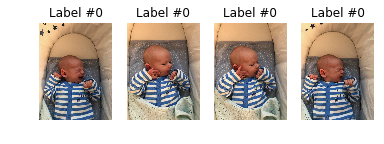

In [17]:
# plot images generated from the dataset - prior to transformation
# import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(len(PIL_harper)):
    
    ax = plt.subplot(1, 4, i + 1)
    
    ax.imshow(PIL_harper[i][0])
    ax.set_title('Label #{}'.format(PIL_harper[i][1]))
    ax.axis('off')
    
    if i == 3:
        break

**widki / TODOs**:
* note that we can't do this...we can't return the labels and the data separately - but we might be able to do this with `dataloader`
    * `harper_data, harper_labels = HarperNetDataset(first_function_test)`
* can definitely tidy the code above up with the code I have learnt in the data notebook think amending this will make the images bigger
* we can pass the load_images function in to the e.g.:
    * `image, target_image = load_images(self.paths[index])`

### Transforms 
* We create a `transform` function and pass this to the dataset function. `transforms.Compose`is a callable class that allows us to perform transformations on images. Using `transforms.Compose`. we can add in custom transform classes, or use those provided.
    * This will include `ToTensor()`, operations for Data Augmentation, and then anything that is required for our transfer learning networks. 
    * If we don't create a PIL Image then we have a `ToPILImage()` transform, that needs to be applied to all the datasets we create - transforms require a PIL image 
    * Order matters for the transforms - look this up 

In [28]:
# we create our transforms as an transform.Compose object that we pass specific operations to it
# lets create some transforms to cycle through and demonstrate 
from torchvision import transforms

resize = transforms.Compose([transforms.Resize((256,256))])

# remember, order matters!
resize_crop = transforms.Compose([resize,
                                   transforms.RandomCrop(224)])

(256, 256)
(224, 224)


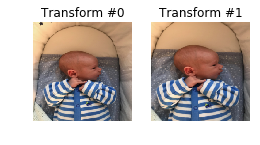

In [48]:
# let's loop through the transforms and see what they look like

# create our figure for plotting
fig = plt.figure()

# define a sample
sample = PIL_harper[12][0]

for i, process in enumerate([resize,resize_crop]):
    
    # apply transformation
    transformed_sample = process(sample)

    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(transformed_sample)
    ax.set_title('Transform #{}'.format(i))
    ax.axis('off')
    print(transformed_sample.size)
 

In [56]:
# end with our define list of transforms and pass them to our Dataset method
transform = transforms.Compose([resize,
                                transforms.RandomCrop(224),
                                transforms.ToTensor()])

In [57]:
transformed_dataset = HarperNetDataset(PIL_function_test, transform=transform)

In [59]:
for i in range(10):
    
    sample = transformed_dataset[i][0]
    label = transformed_dataset[i][1]
    
    print(i, sample.size(), label)

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0
4 torch.Size([3, 224, 224]) 0
5 torch.Size([3, 224, 224]) 0
6 torch.Size([3, 224, 224]) 0
7 torch.Size([3, 224, 224]) 0
8 torch.Size([3, 224, 224]) 0
9 torch.Size([3, 224, 224]) 0


**TODO**
* I think we need to generate separate transforms and datasets for each of the train, test, val sets, that then need to be passed to the dataloader 

### Data Loader
* When we transform the images, what happens to them, does each transform generate another input into the NN, with an associated (provided) label? 
    * NO, see here: https://discuss.pytorch.org/t/data-augmentation-in-pytorch/7925
    * Basically, augmentation means that each at training epoch the images are modified as per the augmentation - in a way we are adding noise, noise is good to prevent overfitting and improve the generalisation of the model 
* Do I need to revisit what libraries I use for reading and showing images? plt, PIL, skimage? (Cover this in the presentation). **widki** look up more on PIL. 

In [60]:
batch_size = 32

train_loader = DataLoader(transformed_dataset,batch_size=batch_size, num_workers=4)

In [64]:
for i, (data, target) in enumerate(train_loader):
    print(data)
    print(target)
    

tensor([[[[ 0.9569,  0.9569,  0.9608,  ...,  0.6510,  0.6588,  0.6588],
          [ 0.9529,  0.9529,  0.9569,  ...,  0.6549,  0.6588,  0.6588],
          [ 0.9647,  0.9569,  0.9608,  ...,  0.6510,  0.6549,  0.6549],
          ...,
          [ 0.8235,  0.7882,  0.8314,  ...,  0.6118,  0.6314,  0.6471],
          [ 0.8471,  0.8353,  0.7765,  ...,  0.6078,  0.6235,  0.6431],
          [ 0.8314,  0.8275,  0.7412,  ...,  0.6039,  0.6275,  0.6392]],

         [[ 0.8039,  0.8039,  0.8078,  ...,  0.5294,  0.5333,  0.5294],
          [ 0.8078,  0.8039,  0.8039,  ...,  0.5294,  0.5333,  0.5294],
          [ 0.8235,  0.8118,  0.8078,  ...,  0.5255,  0.5255,  0.5255],
          ...,
          [ 0.8157,  0.7843,  0.8353,  ...,  0.6000,  0.6118,  0.6235],
          [ 0.8392,  0.8275,  0.7686,  ...,  0.5922,  0.6039,  0.6196],
          [ 0.8314,  0.8235,  0.7333,  ...,  0.5843,  0.6000,  0.6157]],

         [[ 0.5882,  0.5882,  0.5922,  ...,  0.4078,  0.4118,  0.4078],
          [ 0.5922,  0.5882,  

tensor([[[[ 0.9608,  0.9608,  0.9608,  ...,  0.5961,  0.6039,  0.6118],
          [ 0.9569,  0.9569,  0.9608,  ...,  0.6039,  0.6118,  0.6275],
          [ 0.9569,  0.9647,  0.9647,  ...,  0.6118,  0.6235,  0.6392],
          ...,
          [ 0.8745,  0.8627,  0.8510,  ...,  0.3020,  0.3059,  0.3294],
          [ 0.8667,  0.8627,  0.8314,  ...,  0.3098,  0.3137,  0.3255],
          [ 0.8549,  0.8510,  0.7843,  ...,  0.3176,  0.3255,  0.3294]],

         [[ 0.8784,  0.8784,  0.8824,  ...,  0.4588,  0.4706,  0.4824],
          [ 0.8745,  0.8745,  0.8745,  ...,  0.4706,  0.4784,  0.4902],
          [ 0.8667,  0.8667,  0.8667,  ...,  0.4784,  0.4863,  0.5020],
          ...,
          [ 0.8118,  0.8000,  0.7882,  ...,  0.3020,  0.3059,  0.3294],
          [ 0.8000,  0.7922,  0.7686,  ...,  0.3098,  0.3137,  0.3255],
          [ 0.7882,  0.7804,  0.7216,  ...,  0.3176,  0.3255,  0.3294]],

         [[ 0.6706,  0.6706,  0.6745,  ...,  0.3569,  0.3608,  0.3647],
          [ 0.6627,  0.6627,  

tensor([[[[ 0.3882,  0.3882,  0.3922,  ...,  0.3255,  0.3294,  0.3294],
          [ 0.3804,  0.3843,  0.3843,  ...,  0.3216,  0.3255,  0.3255],
          [ 0.3804,  0.3804,  0.3843,  ...,  0.3216,  0.3255,  0.3255],
          ...,
          [ 0.8078,  0.8000,  0.7843,  ...,  0.8196,  0.8314,  0.8353],
          [ 0.8157,  0.8039,  0.7922,  ...,  0.8118,  0.8157,  0.8235],
          [ 0.8235,  0.8078,  0.8000,  ...,  0.8235,  0.8157,  0.8157]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.3333,  0.3373,  0.3412],
          [ 0.3725,  0.3725,  0.3725,  ...,  0.3333,  0.3333,  0.3333],
          [ 0.3686,  0.3686,  0.3725,  ...,  0.3333,  0.3333,  0.3294],
          ...,
          [ 0.7647,  0.7569,  0.7412,  ...,  0.7804,  0.7882,  0.7922],
          [ 0.7725,  0.7608,  0.7529,  ...,  0.7725,  0.7725,  0.7804],
          [ 0.7725,  0.7608,  0.7529,  ...,  0.7804,  0.7725,  0.7725]],

         [[ 0.3451,  0.3451,  0.3451,  ...,  0.3294,  0.3333,  0.3333],
          [ 0.3373,  0.3373,  

In [63]:
len(train_loader)

4

**Saturday**
* Define transforms
* define data loader
* get data split between train, test, val
* use preexisting model as model.py
* execute a training run with model
**Sunday**
* Get better data set, use two classes but more images
* Build inference model
* Get code in files and on github
* Train new model, see if you need GPU 
**Monday**
* Refine dataset 
* Start to understand options for training and best practices